In [1]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

def standardize(x):
    return (x - x.mean(axis=1, keepdims=True)) / (x.std(axis=1, keepdims=True) + 1e-8)

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x ** 3)))

In [2]:
def plot_multi_traj(logits, n_temps=1000, log_temps_low=-2, log_temps_high=2):

    trans_logits = gelu(standardize(logits) - .5)
    trans_logits = np.sign(trans_logits) * np.abs(trans_logits) ** 2 * 3

    thetas = 2 * np.pi * np.arange(logits.shape[1]) / logits.shape[1]
    T = np.stack([np.sin(thetas), np.cos(thetas)], axis=1)
    fig, axs = plt.subplots(2, len(log_temps_low), figsize=(6, 2.9))

    assert len(log_temps_low) == len(log_temps_high)
    for id in range(len(log_temps_low)):

        temps = np.logspace(log_temps_low[id], log_temps_high[id], n_temps)
        min_temp_str = f"{temps.min():.0f}" if temps.min() >= 1 else f"{temps.min()}"
        max_temp_str = f"{temps.max():.0f}" if temps.max() >= 1 else f"{temps.max()}"

        probs = np.stack([
            softmax(logits / temp, axis=1) for temp in temps
        ], axis=2)
        trans_probs = np.stack([
            softmax(trans_logits / temp, axis=1) for temp in temps
        ], axis=2)

        coords = np.einsum('ijk,jl->ilk', probs, T)
        trans_coords = np.einsum('ijk,jl->ilk', trans_probs, T)

        for id2 in [0, 1]:
            axs[id2, id].set_aspect('equal')
            axs[id2, id].set_xlim(-.867, .867)
            axs[id2, id].set_yticks([])
            axs[id2, id].set_xticks([])
            for spine in axs[id2, id].spines.values():
                spine.set_visible(False)

            # Plot the probability simplex
            for ind in range(T.shape[0]):
                axs[id2, id].plot(T[ind:ind+2, 0], T[ind:ind+2, 1], 'k--')
            axs[id2, id].plot(T[[0, -1], 0], T[[0, -1], 1], 'k--')

        for i in range(coords.shape[0]):
            label = '(' + ', '.join(
                f'{l:.0f}' if l % 1 == 0 else f'{l}' for l in logits[i, :]
            ) + ')'
            axs[0, id].plot(
                coords[i, 0, :], coords[i, 1, :], label=label
            )
            axs[1, id].plot(
                trans_coords[i, 0, :], trans_coords[i, 1, :], label=label
            )
            axs[0, id].set_title(rf"$T \in [{min_temp_str}, {max_temp_str}]$")

        axs[0, 0].set_ylabel(r"$\sigma (\frac{h (\cdot)} {T})$", fontsize='x-large')
        axs[1, 0].set_ylabel(r"$\sigma (\frac{h^{map} (\cdot)} {T})$", fontsize='x-large')

    handles, labels = axs[-1, -1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.532, .91))
    plt.tight_layout()
    plt.savefig('traj.pdf', bbox_inches='tight')
    plt.show()

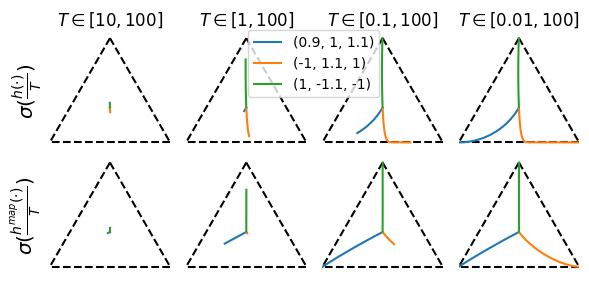

In [3]:
logits = np.array([[.9, 1, 1.1], [-1, 1.1, 1], [1, -1.1, -1]])
plot_multi_traj(logits, log_temps_low=[1, 0, -1, -2], log_temps_high=[2, 2, 2, 2])